Cyberbot I
===


do a write-up where we go deeper on some pairs - pick 2 self reverting and 1 bot-bot reverting combination -- each take one bot. can do in spreadsheet or notebook. go beyond bullet pointed list -- write a summary of why bot exists, what it does, why it gets reverted. give us a case study. what is the thing that is trying to be done here? deepen qualitative understanding

* why exist
* how long operational
* what percentage reverts
* why reverts itself
* how does it work

points not in order. collect as many links as you can. if find interesting rev, copy url and write why interesting. klepto approach - take as many as you can


# summary of findings 7/2/21

### background

The oldest approval request for Cyberbot I is from March 2012, when the operator first took over a task from SoxBot. Since then the operator has added more and more tasks to Cyberbot I's agenda. Cyberbot I is unique in that all of its tasks were taken over from other bots, using those bots' original code. The code was not initially publicly available, but does now have a git repository listed below. Out of all Cyberbot's edits in the 3 weeks examined, 13.2% were reverted within 24 hours. However, only 0.3% of the total edits were reverted by users other than Cyberbot, with the remaining 12.8% being self reverts. Cyberbot performed edits in 8 different namespaces during this time, with the vast majority of edits taking place in namespaces 2, 10, 109, and 4 (User, Template, Book Talk, and Wikipedia). The vast majority of self-reverted edits were in namespace 2, User, while the vast majority of edits reverted by others were in namespace 4, Wikipedia.


### tasks

According to Cyberbot I's User page, the bot has 14 different functions. The most prevalent tasks seem to be updating Admin stats pages in the template namespace (10), BookReports in namespace Book Talk (109), and updating the RfX Tally page in the User namespace (2). However, it is difficult to isolate exactly what percentage of edits is spent on each task, so these are just educated guesses at this point.


### reverts

The vast majority of Cyberbot I's self-reverts seem to be on the User:Cyberpower678/Tally page, where Cyberbot keeps track of the current votes n RfX elections. The cause is unclear. You would think that the bot would update the numbers, but the number of votes always seem to remain the same.

About half of all reverts by others happen when people delete Cyberbot's template from the sandbox. The other half are much more confusing and may indicate malfunctions of the bot, or at least mistakes. These reverts require further analysis.


### possible malfunctions found

* 879127746 - Cyberbot changes someone's admin stats, but the numbers go way down, which is impossible. Across the next few edits, the numbers back up but still decrease a bit every once in awhile.
* 876710826 - start of a chain of edits where Cyberbot reverts users changing its page 3 times.
* 877919965 - Cyberbot adds an AfD template to an article whose discussion already closed.
* 877957992 & 878282200 - Cyberbot blanks WP:CHUS for an unknown reason. Another user undoes these edits.

All of these edits have ORES damaging scores <= 0.011.


### fight with users

In a sequence of edits starting with edit 876710826, a user changes Cyberpower678:Tally to mention another bot, presumably so that this other bot can take over the task since the user mentions that Cyberbot I needs to be fixed. Cyberbot reverts this edit. Another user makes the same edit, and Cyberbot reverts it again. The user tries a {{nobots}} template, Cyberbot reverts it again. The user decides to move the page. Cyberbot has not edited that page since then. However, this sequence of edits seems to happen every year or so on that page.

### ORES scores

Cyberbot I has very low ORES damaging scores. The highest damaging score was 0.051, quickly dropping off to an average score of 0.0078. An analyzation of the top 20 ORES damaging scores did not reveal any problematic edits.

subsetting the data
===

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from datetime import datetime

In [4]:
df = pd.read_csv('revs_scored_jan.tsv', sep='\t', header=0)

In [5]:
days = df.rev_timestamp.map(lambda ts: datetime.utcfromtimestamp(ts).day)
df['day'] = days

In [6]:
# isolate data to only data from Jan1-Jan21, edits by Cyberbot

sdf = df[df.day<22]
df_cyberbot = sdf[sdf.user_text == "Cyberbot I"]

In [7]:
len(df_cyberbot)

7824

In [8]:
sdf_another = df[df.is_revert]

cyberbot_reverted = df_cyberbot[df_cyberbot.is_reverted]
cyberbot_reverted = cyberbot_reverted[cyberbot_reverted.seconds_to_revert.astype('str').astype('int')<86400]

In [9]:
sdf1 = cyberbot_reverted.loc[cyberbot_reverted.is_reverted, ["rev_id", "user_text", "revert_id", "page_namespace", "page_id", "damaging_pred"]]
sdf1.revert_id = sdf1.revert_id.astype('int')

sdf2 = sdf_another[["rev_id", 'user_text', "is_self_revert", "user_is_bot", "page_id"]]

In [10]:
all_reverts = pd.merge(sdf1, sdf2, 
             how='inner', 
             left_on='revert_id', 
             right_on='rev_id', 
             suffixes=('', '_reverter')
)

In [11]:
all_reverts['reverting_user_is_bot'] = all_reverts['user_is_bot']
del all_reverts["user_is_bot"]

In [12]:
self_reverts = all_reverts[all_reverts.user_text_reverter == "Cyberbot I"]
non_self_reverts = all_reverts[all_reverts.user_text_reverter != "Cyberbot I"]

In [13]:
# variables at this point:
#   df
#   df_cyberbot = all edits by cyberbot
#   cyberbot_reverted = all of cyberbots edits which were reverted w/in 24 hours
#   all_reverts = all of cyberbot's edits reverted w/in 24 hours, with both original rev_id and revert_id
#     self_reverts = all of cyberbot's edits which it self-reverted w/in 24 hours
#     non_self_reverts = all of cyberbot's edits which were reverted by someone else w/in 24 hours

In [14]:
sdf1 = df.loc[df.is_reverted, ["rev_id", "user_text", "revert_id", "page_namespace", "page_id", "damaging_pred"]]
sdf1.revert_id = sdf1.revert_id.astype('int')

sdf2 = df_cyberbot.loc[df_cyberbot.is_revert, ["rev_id", 'user_text', "is_self_revert", "user_is_bot", "page_id"]]

In [15]:
reverts_of_others = pd.merge(sdf1, sdf2, 
             how='inner', 
             left_on='revert_id', 
             right_on='rev_id', 
             suffixes=('', '_reverter')
)

In [16]:
# additional variable:
# reverts_of_others = all times cyberbot reverted someone else, including itself

# what percentage of cyberbot's edits were reverted within 24 hours?


In [17]:
len(all_reverts) / len(df_cyberbot) 

0.13164621676891616

## percentage self reverted

In [18]:
len(self_reverts) / len(df_cyberbot)

0.12832310838445807

## percentage reverted by others

In [19]:
len(non_self_reverts) / len(df_cyberbot)

0.0033231083844580778

percentage reverted by others is so small! 0.33%. almost all reverts are self reverts

In [20]:
len(non_self_reverts)

26

## who reverted them?

In [21]:
cyberbot_reverting_users = all_reverts.groupby('user_text_reverter').count().sort_values('rev_id', ascending=False).reset_index()

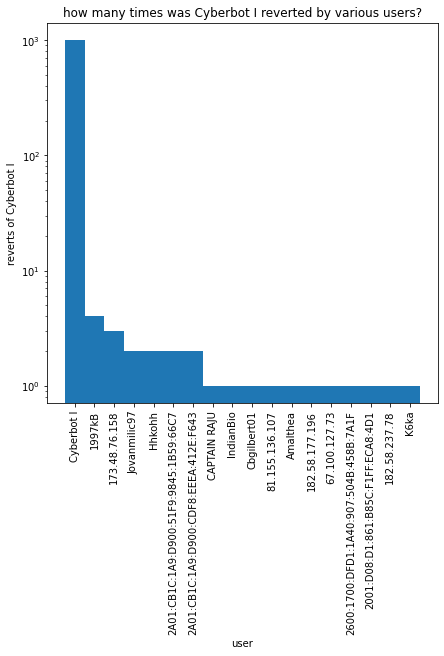

In [22]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
y = range(len(cyberbot_reverting_users))
axes.bar(y, cyberbot_reverting_users.rev_id, width=1)
axes.set_yscale('log')
axes.set_xticks(y)
axes.set_xticklabels([f"{row.user_text_reverter}" for row in cyberbot_reverting_users.itertuples()], rotation=90)

axes.set_title("how many times was Cyberbot I reverted by various users?")
axes.set_xlabel("user")
axes.set_ylabel("reverts of Cyberbot I")
plt.show()

Cyberbot requests for approval
===


zeroth request for approval: March 2012 https://en.wikipedia.org/wiki/Wikipedia:Bots/Requests_for_approval/Cyberbot_I
* request eventually withdrawn
* operator made mistakes in application (programming language, not specific enough about tasks)
* trying to take over all tasks of SoxBot, old bot whose operator retired
* people were concerned that he had bitten off more than he could chew by trying to take over all of SoxBot's tasks at once
* source code "coming soon"

first request for approval: March 2012 https://en.wikipedia.org/wiki/Wikipedia:Bots/Requests_for_approval/Cyberbot_I_1
* about 3 weeks after last one
* function: taking over SoxBot's badimage task, same code
* had trial, then extended trial before being approved

note: meaning of transclusion?

second request for approval: August 2012 https://en.wikipedia.org/wiki/Wikipedia:Bots/Requests_for_approval/Cyberbot_I_2
* request is several months later
* functions: "adminstats, cratstats, RfX reporter, tally"
* code available "upon request" - not openly available
* speedily approved

third request for approval: February 2013 https://en.wikipedia.org/wiki/Wikipedia:Bots/Requests_for_approval/Cyberbot_I_3
* again about 6 months later
* function details: "This is an amendment to the adminstats task based off of a couple of requests. As it currently is running, Adminstats are only providing statistics to admins because it acts as an edit counter for non admins which violates WP:BOTPOL. Another statistic that adminstats display is number of accounts being created. I want to open adminstats to account creators now. Per WP:BOTPOL that is technically allowed, but I want input from BAG."
* source code available says no! not available at all I suppose... why?
* approved


fourth request: July 2013 https://en.wikipedia.org/wiki/Wikipedia:Bots/Requests_for_approval/Cyberbot_I_4
* function: takeover of SnotBot, temporary
* specific tasks: are snotbot 10 and 12
* about 6 months later again
* speedily approved

fifth request: July 2013 https://en.wikipedia.org/wiki/Wikipedia:Bots/Requests_for_approval/Cyberbot_I_5
* takeover of Noombot's bookreport script
* approved

sixth request: August 2013 https://en.wikipedia.org/wiki/Wikipedia:Bots/Requests_for_approval/Cyberbot_I_6
* function: create current events page, one of SoxBot's tasks using its original code
* approved

seventh request: July 2015 https://en.wikipedia.org/wiki/Wikipedia:Bots/Requests_for_approval/Cyberbot_I_7
* take over clerking script from Legobot
* approved

eighth (and final) request: October 2015 https://en.wikipedia.org/wiki/Wikipedia:Bots/Requests_for_approval/Cyberbot_I_8
* function: clean the sandbox. old soxbot code, modified
* approved
* source code is now available!
* runs hourly

# code

https://github.com/cyberpower678/

note: most recent commit was 2 years ago. most of the code is from 5 years ago

note: all of the code is in folders according to which bot cyberbot I took over the task for. possibly why the user lists the tasks the way he does.

note: cyberbot I seems pretty unique in the fact that all of its code / tasks were originally belonging to other bots

# namespaces

https://en.wikipedia.org/wiki/Wikipedia:Namespace

In [23]:
all_namespaces = df_cyberbot.groupby("page_namespace").count().sort_values("rev_id", ascending=False)

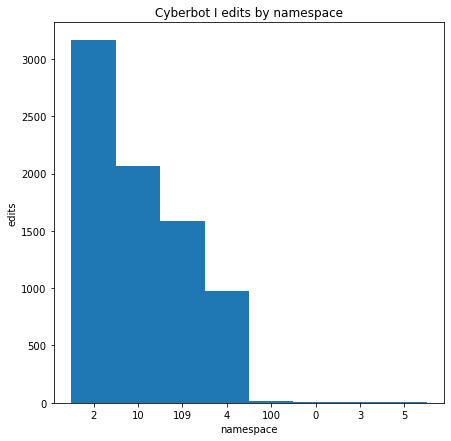

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
y = range(len(all_namespaces))
axes.bar(y, all_namespaces.rev_id, width=1)
axes.set_xticks(y)
axes.set_xticklabels([f"{row.Index}" for row in all_namespaces.itertuples()], rotation=0)

axes.set_title("Cyberbot I edits by namespace")
axes.set_xlabel("namespace")
axes.set_ylabel("edits")
plt.show()

In [25]:
rev_namespaces = cyberbot_reverted.groupby("page_namespace").count().sort_values("rev_id", ascending=False)

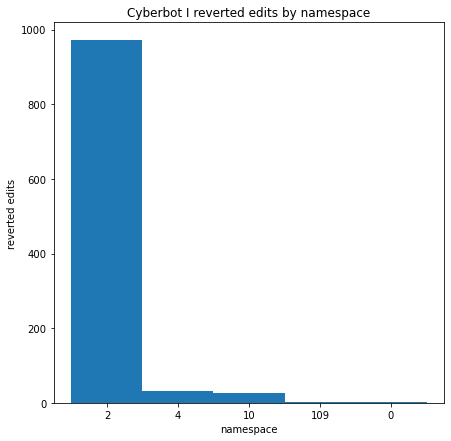

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
y = range(len(rev_namespaces))
axes.bar(y, rev_namespaces.rev_id, width=1)
axes.set_xticks(y)
axes.set_xticklabels([f"{row.Index}" for row in rev_namespaces.itertuples()], rotation=0)

axes.set_title("Cyberbot I reverted edits by namespace")
axes.set_xlabel("namespace")
axes.set_ylabel("reverted edits")
plt.show()

In [27]:
self_rev_namespaces = self_reverts.groupby("page_namespace").count().sort_values("rev_id", ascending=False)

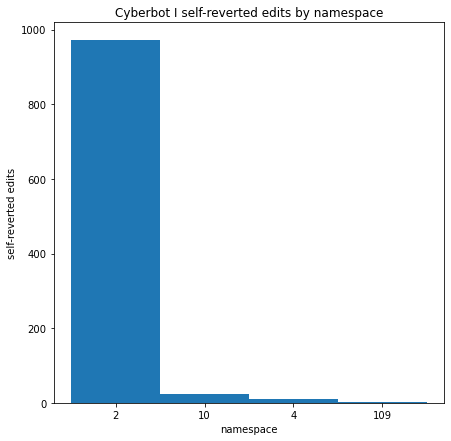

In [28]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
y = range(len(self_rev_namespaces))
axes.bar(y, self_rev_namespaces.rev_id, width=1)
axes.set_xticks(y)
axes.set_xticklabels([f"{row.Index}" for row in self_rev_namespaces.itertuples()], rotation=0)

axes.set_title("Cyberbot I self-reverted edits by namespace")
axes.set_xlabel("namespace")
axes.set_ylabel("self-reverted edits")
plt.show()

In [29]:
nonself_rev_namespaces = non_self_reverts.groupby("page_namespace").count().sort_values("rev_id", ascending=False)

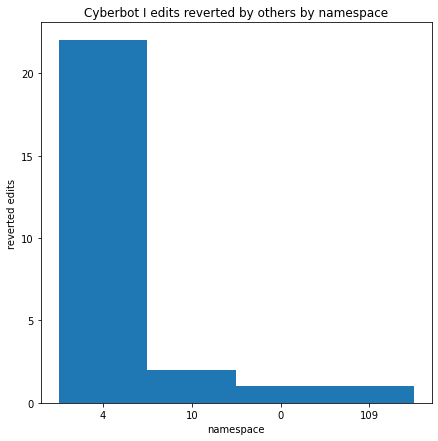

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
y = range(len(nonself_rev_namespaces))
axes.bar(y, nonself_rev_namespaces.rev_id, width=1)
axes.set_xticks(y)
axes.set_xticklabels([f"{row.Index}" for row in nonself_rev_namespaces.itertuples()], rotation=0)

axes.set_title("Cyberbot I edits reverted by others by namespace")
axes.set_xlabel("namespace")
axes.set_ylabel("reverted edits")
plt.show()

# Cyberbot functions


user page: https://en.wikipedia.org/wiki/User:Cyberbot_I

listed tasks, only currently enabled ones:
* SandBot: cleans sandbox every hour, ones on talk pages every 12 hours
    * namespace 4
* BadImageBot: maintains the bad image list by finding instances of https://en.wikipedia.org/wiki/Template:Badimage / https://en.wikipedia.org/wiki/Template:Restricted_use
    * adding template does nothing, just leaves a note on the image
    * cyberbot finds instances of the template and adds the image to the bad image list
    * transclusion https://en.wikipedia.org/wiki/Help:Transclusion seems extremely confusing
    * namespace 10? possibly no edits in this category in this month
* CurrentEventsBot: generates current event pages for the next day
* AdminStatsBot: updates the adminstats template with info about admin actions (deletes, blocks) https://en.wikipedia.org/wiki/Template:Adminstats
    * place template on userpage or user subpage, bot creates stats page and updates it every 24 hours
    * gives info about number of pages / revisions deleted, users blocked / unblocked, that sort of thing
    * namespace 10
* CratStats: updates the cratstats template with info about open AfAs, RfBs, CHU requests https://en.wikipedia.org/wiki/Template:Cratstats
    * AfA -> RfA (request for adminship), want to become admin
    * RfB (request for bureaucratship)
    * CHU - no idea
    * cratstats also shows BRFAs (bot requests for approval)
    * namespace 10
* RfX reporter: updates User:Cyberpower678/RfX_Report with info about current RfAs and RfBs 
    * https://en.wikipedia.org/wiki/User:Cyberpower678/RfX_Report
    * shows candidate, time left, tally of votes
    * namespace 2
* RfX TallyBot: updates Cyberpower678/Tally with the current tallies of all the open RfXs
    * visible content of page: only (?/?/?)
    * not visible content: various usernames, all with (0/0/0) next to them. why are all the counts 0?
    * did find one version with actual numbers, only in first loc. shows numbers matching S/O/N (Support/Oppose/Neutral) format on RfX report page?
    * namespace 2
* AdminHighlighterBot: creates a list of admins at User:Cyberbot_I/adminrights-admins.js for another bot? Ais523's highlighter script
    * Ais523 is a semi-retired user who writes scripts
    * page is literally just a list of users with admin rights
    * namespace 2
* DateFixBot: date fixes maintenance tags
    * can't find much, but I assume this means tags such as ref needed or original research
    * another approval request from March 2012: https://simple.wikipedia.org/wiki/Wikipedia:Bots/Fulfilled_requests/2012#Cyberbot_I
* BookReportBot: generates reports for books within Category:Wikipedia_books_(community_books)
    * https://en.wikipedia.org/wiki/Category:Wikipedia_books_(community_books)
    * books namespace is now officially deprecated, going to be deleted. guess this won't be running anymore, but still running at the time of data
    * namespace 109
* AfDBot: clerks at AfDs (converted to PHP - originally SnotBot python)
    * https://en.wikipedia.org/wiki/Wikipedia:Articles_for_deletion
    * articles for deletion
    * found only one cyberbot edit, transcluding something
    * most edits pertaining to this seem to be on page: https://en.wikipedia.org/wiki/User:Cyberbot_I/Current_AfD%27s
    * namespaces 2 and 4
* RfPPBot: clerks and archives at RfPP (converted to PHP - originally SnotBot python)
    * requests for page protection https://en.wikipedia.org/wiki/Wikipedia:Requests_for_page_protection
    * several instances of bot archiving threads
    * namespace 4
* RfUBot: maintains unblock table for users requesting unblock (converted to PHP - originally SnotBot python)
    * https://en.wikipedia.org/wiki/User:Cyberbot_I/Requests_for_unblock_report
    * info about when blocked, when last edit, etc
    * namespace 2
* CHUBot: clerks at WP:CHUS
    * https://en.wikipedia.org/wiki/Wikipedia:Changing_username/Simple
    * requests to change username
    * notes if there are any issues with the requested username (another user already has that name or contains unusable characters)
    * namespace 4

note: all of the tasks listed on this page seem to have been covered by another bot at one point and added to cyberbot I's list. user has cyberbot II for his own code possibly?

### attempting to isolate how many edits in some tasks

In [31]:
len(df_cyberbot[df_cyberbot.page_id == 35159788]) / len(df_cyberbot) # 35159788 is the id of the Cyberpower678:Tally page - appx percentage of edits in RfXTally

0.12167689161554192

In [32]:
len(df_cyberbot[df_cyberbot.page_namespace == 109]) / len(df_cyberbot) # 109 is the book talk namespace - appx percentage of edits on BookReport task

0.20283742331288343

In [33]:
len(df_cyberbot[df_cyberbot.page_id == 16283969]) / len(df_cyberbot) # 16283969 is id of WP:Sandbox - appx percentage of WP:sandbox edits, but there are other sandboxes

0.02338957055214724

In [34]:
len(df_cyberbot[df_cyberbot.page_id == 20642622]) / len(df_cyberbot) # 20642622 is cratstats page id - appx percentage of cratstats edits

0.006901840490797546

In [35]:
(len(df_cyberbot[df_cyberbot.page_namespace == 10]) - len(df_cyberbot[df_cyberbot.page_id == 20642622])) / len(df_cyberbot) # possible percentage of other template edits - admin stats updates, but may be less

0.25690184049079756

other functions would be more difficult to isolate - other namespaces have multiple tasks, multiple pages

# Cyberbot I: random sample of edits and analysis

In [36]:
df_cyberbot.sample(n=20, random_state=10)[["rev_id", "page_id", "is_minor", "is_revert", "is_reverted", "page_namespace", "seconds_to_prev", "damaging_pred", "goodfaith_pred"]].reset_index()

,index,rev_id,page_id,is_minor,is_revert,is_reverted,page_namespace,seconds_to_prev,damaging_pred,goodfaith_pred
0,604511,876857914,352651,False,False,False,4,73,0.006925,0.991412
1,166853,876400051,45514171,True,False,False,109,6431770,0.008596,0.994566
2,25927,876254025,39008263,True,False,False,10,85800,0.008977,0.993623
3,1579570,877870409,42414676,True,False,False,109,11560743,0.006855,0.995447
4,158789,876391750,35159700,False,False,False,2,1557,0.007126,0.990445
5,2928072,879276370,21083350,True,False,False,10,88589,0.010086,0.991916
6,2785160,879127746,48564490,True,False,True,10,3890847,0.010453,0.990951
7,2960799,879310786,35159700,False,False,False,2,209,0.013086,0.990231
8,839153,877101856,16283969,False,True,False,4,1836,0.011849,0.993206
9,2012462,878321999,45160445,True,False,False,10,83901,0.010055,0.992097


0. 876857914 on RfPP page, re-ordered requests according to time stamps
1. 876400051 part of bookreport task. changing article status (to what their pages currently say?) and adds "|non-free=" to template
2. 876254025 updating someone's admin stats
3. 877870409 part of bookreport task. removed a gif from the report (can't be included in a book?)
4. 876391750 on RfX report, updated count for a vote and timestamp of latest update
5. 879276370 updating someone's admin stats
6. 879127746 updating someone's admin stats, except ***note: possible malfunction, stats go way down*** month long break since last edit. they later go back up in the next edit. as I skip through edits, they keep going up and down a bit, but never by as much as in the original edit
7. 879310786 adds RfB to RfX page and deletes line that says there are no current RfXs
8. 877101856 clears sandbox of all content, preserving header
9. 878321999 updating admin stats
10. 878493763 AfD report. list of AfD's which are apparently closed but remain on CAT:AfD. made no substantial changes, only updated time that page was last updated by the bot
11. 877805941 updating current AfD's list under its own user page.
12. 876411075 updating RfU page, time of last update and adding requests
13. 878300940 part of bookreport task, updating the status of an article to GA and changing count accordingly
14. 878977612 updating admin stats
15. 879125181 updating admin stats
16. 877860705 created bookreport for a new book
17. 876417475 updating admin stats
18. 876586515 updating admin stats
19. 878843141 updating RfU page, adding users and changing time of last update

# Cyberbot I: random sample of self-reverted edits and analysis

In [37]:
self_reverts.sample(n=20, random_state=10)[["rev_id", "revert_id", "page_namespace", "is_self_revert", "page_id"]].reset_index()

,index,rev_id,revert_id,page_namespace,is_self_revert,page_id
0,969,878532936,878554876,2,True,35159788
1,301,876393226,876393229,2,True,35159788
2,178,876334242,876334447,2,True,35159788
3,802,876618286,876618291,2,True,35159788
4,913,876713455,876713765,2,True,35159700
5,180,876334450,876335938,2,True,35159788
6,678,876608376,876608377,2,True,35159788
7,296,876390948,876390950,2,True,35159788
8,632,876603770,876603772,2,True,35159788
9,1008,879099269,879112674,2,True,35159788


0. 878532936 first one deletes 2 users and counts from Cyberpower678/Tally, second adds same users, same counts again. edits are 4 hours apart
1. 876393226 first one deletes 2 users and counts from Cyberpower678/Tally, second adds same users, same counts again. edits are in same minute
2. 876334242 first one adds 2 users and counts to Cyberpower678/Tally, second deletes same users, same counts again. edits are 2 mins apart
3. 876618286 first one deletes 1 user and count from Cyberpower678/Tally, second adds same user, same counts again. edits are in same minute
4. 876713455 in Cyberpower678/RfX Report, adds an RfB candidate **in the wrong spot?** (says bureaucrat candidate but put under RfA heading). deletes candidate 3 mins later
5. 876334450 first one adds 2 users and counts to Cyberpower678/Tally, second deletes same users, same counts again. edits are 12 mins apart
6. 876608376 first one deletes 1 user and count from Cyberpower678/Tally, second adds same user, same counts again. edits are in same minute
7. 876390948 first one deletes 2 users and counts from Cyberpower678/Tally, second adds same users, same counts again. edits are in same minute
8. 876603770 first one deletes 1 user and count from Cyberpower678/Tally, second adds same user, same count again. edits are in same minute
9. 879099269 first one adds 3 users and counts to Cyberpower678/Tally, second deletes same users, same counts again. edits are 2.5 hours apart
10. 876236234 first one deletes 3 users and counts from Cyberpower678/Tally, second adds same users, same counts again. edits are in same minute
11. 876398793 first one deletes 2 users and counts from Cyberpower678/Tally, second adds same users, same counts again. edits are in same minute
12. 878554876 first one adds 2 users and counts to Cyberpower678/Tally, second deletes same users, same counts again. edits are 2 hours apart
13. 876357917 first one adds 2 users and counts to Cyberpower678/Tally, second deletes same users, same counts again. edits are 1 minute apart
14. 876622438 first one adds 1 user and count to Cyberpower678/Tally, second deletes same user, same count again. edits are 1 minute apart.
15. 876607113 first one deletes 1 user and count from Cyberpower678/Tally, second adds same user, same count again. edits are in same minute
16. 876237731 in Cyberpower678/RfX Report, deletes 2 RfB candidates **in the wrong spot?** (says bureaucrat candidate but put under RfA heading). re-adds candidates in same minute later, with same numbers
17. 876614945 first one adds 1 user and count to Cyberpower678/Tally, second deletes same user, same count again. edits are 4 minutes apart.
18. 876600530 first one adds 2 users and counts to Cyberpower678/Tally, second only one user and count again. edits are 10 minutes apart
19. 876561044 first one adds 2 users and counts to Cyberpower678/Tally, second deletes same users, same counts again. edits are 1 min apart

In [38]:
self_reverts.head(5)[["rev_id", "revert_id", "page_namespace", "is_self_revert"]]

,rev_id,revert_id,page_namespace,is_self_revert
0,876227648,876227653,2,True
1,876227653,876228467,2,True
2,876228467,876228471,2,True
3,876228471,876229970,2,True
4,876229970,876229977,2,True


# Cyberbot I reverts by others (non self-reverts)

In [39]:
len(non_self_reverts)

26

In [40]:
non_self_reverts.groupby("user_text_reverter").count().sort_values("rev_id", ascending=False)

,rev_id,user_text,revert_id,page_namespace,page_id,damaging_pred,rev_id_reverter,is_self_revert,page_id_reverter,reverting_user_is_bot
user_text_reverter,,,,,,,,,,
1997kB,4,4,4,4,4,4,4,4,4,4
173.48.76.158,3,3,3,3,3,3,3,3,3,3
Jovanmilic97,2,2,2,2,2,2,2,2,2,2
Hhkohh,2,2,2,2,2,2,2,2,2,2
2A01:CB1C:1A9:D900:51F9:9845:1B59:66C7,2,2,2,2,2,2,2,2,2,2
2A01:CB1C:1A9:D900:CDF8:EEEA:412E:F643,2,2,2,2,2,2,2,2,2,2
Amalthea,1,1,1,1,1,1,1,1,1,1
IndianBio,1,1,1,1,1,1,1,1,1,1
Cbgilbert01,1,1,1,1,1,1,1,1,1,1


In [41]:
non_self_reverts.groupby("page_namespace").count().sort_values("rev_id", ascending=False)

,rev_id,user_text,revert_id,page_id,damaging_pred,rev_id_reverter,user_text_reverter,is_self_revert,page_id_reverter,reverting_user_is_bot
page_namespace,,,,,,,,,,
4,22,22,22,22,22,22,22,22,22,22
10,2,2,2,2,2,2,2,2,2,2
0,1,1,1,1,1,1,1,1,1,1
109,1,1,1,1,1,1,1,1,1,1


note: user id reverter shows no pattern, but page_namespace does - 4 is where wikipedia sandbox is. also, explains high variability in user text reverter

## random sample of namespace 4 (Wikipedia)

In [42]:
non_self_reverts[non_self_reverts.page_namespace == 4].sample(n=5, random_state=6)[["rev_id", "user_text_reverter", "revert_id", "page_namespace", "is_self_revert", "page_id"]].reset_index()

,index,rev_id,user_text_reverter,revert_id,page_namespace,is_self_revert,page_id
0,1017,879206511,2A01:CB1C:1A9:D900:CDF8:EEEA:412E:F643,879206585,4,False,16283969
1,946,878004584,67.100.127.73,878004742,4,False,16283969
2,933,877919961,Jovanmilic97,877928278,4,False,59626130
3,941,877957992,Hhkohh,877966355,4,False,7535778
4,960,878282200,1997kB,878307466,4,False,7535778


In [43]:
non_self_reverts[non_self_reverts.page_namespace == 4].sample(n=5, random_state=10)[["rev_id", "user_text_reverter", "revert_id", "page_namespace", "is_self_revert", "page_id"]].reset_index()

,index,rev_id,user_text_reverter,revert_id,page_namespace,is_self_revert,page_id
0,979,878737151,CAPTAIN RAJU,878739027,4,False,53315132
1,933,877919961,Jovanmilic97,877928278,4,False,59626130
2,915,877094783,182.58.177.196,877094836,4,False,16283969
3,963,878339112,173.48.76.158,878371470,4,False,16283969
4,946,878004584,67.100.127.73,878004742,4,False,16283969


0. 879206511 in sandbox, cydebot clears everything. in same minute, a user adds new stuff to page.
1. 878004584 a minute after cyberbot clears everything from sandbox, someone actually undoes cyberbot's edit to restore their content
2. 877919961 on Wikipedia:Articles for deletion/Shari Thurer, cydebot adds automated comment about not being included on another page. another user closes discussion and removes Cyberbot's comment.
3. 877957992 on WP:CHUS, cyberbot blanks page for an unknown reason. another user undid Cyberbot's revision. **weird** 11 Jan 18:20
4. 878282200 again on WP:CHUS, cyberbot blanks page and another user undoes it. **very weird** 13 Jan 18:40


another random sample - need more info

0. 878737151 16 Jan Wikipedia:Articles for deletion/Pradeep Chandran, cyberbot deletes template from closed AfD, another user removes some stuff from page. edits don't seem related
1. above
2. 877094783 in sandbox, cyberbot clears content, another user undoes the edit to get their content back
3. 878339112 cyberbot clears content of sandbox, another user deletes template and adds their own stuff
4. above

In [44]:
len(non_self_reverts[(non_self_reverts.page_namespace == 4) & (non_self_reverts.page_id == 16283969)])

14

I was wrong - out of 26 total edits, only 14 are in the sandbox. 4 are in other namespaces, which leaves 8 edits in the WP namespace reverted by others

## other namespaces (10, 0, 109)

In [45]:
non_self_reverts[non_self_reverts.page_namespace != 4][["rev_id", "user_text_reverter", "revert_id", "page_namespace", "is_self_revert", "page_id"]].reset_index()

,index,rev_id,user_text_reverter,revert_id,page_namespace,is_self_revert,page_id
0,547,876559900,IndianBio,876616622,109,False,47773938
1,911,876710826,Hhkohh,876717129,10,False,22840568
2,934,877919965,Jovanmilic97,877928337,0,False,1997986
3,1006,879005465,Amalthea,879011278,10,False,22840568


0. 876559900 cyberbot updates book report, removing files. another user undoes the edit next day
1. 876710826 on 3 january, user changes cyberbot's RfX tally to mention another bot. edit summary "alternative until bot is fixed." **was cyberbot broken?** cyberbot undoes this edit, and another user undoes cyberbot's edit.
2. 877919965 on Shari Thurer article, cyberbot adds AfD template because article is still at AfD but no template. another user deletes the template an hour later but provides no edit summary. Jan 11. found decision for AfD on talk page - keep, put there 9:08 11 Jan, hence before Cyberbot made this edit - **another malfunction.** uncertain whether Cyberbot was functioning as intended.
    * related to 2 above https://en.wikipedia.org/w/index.php?title=Wikipedia:Articles_for_deletion/Shari_Thurer_(2nd_nomination)&action=history
    * discussion closed 9:08 11 Jan, hence before cyberbot made this edit
3. 879005465 continuation of 1 above, cyberbot undoes the other user undoing it. user makes edit again with a {{nobots}} flag an **interesting fight between users and bots!**

# Cyberbot I reverts of other people

In [46]:
len(reverts_of_others)

1584

In [47]:
len(reverts_of_others[reverts_of_others.user_text != "Cyberbot I"])

479

In [48]:
reverts_of_others[reverts_of_others.user_text != "Cyberbot I"].sample(n=20, random_state=2)

,rev_id,user_text,revert_id,page_namespace,page_id,damaging_pred,rev_id_reverter,user_text_reverter,is_self_revert,user_is_bot,page_id_reverter
1504,879007171,180.211.169.82,879011158,4,16283969,0.106597,879011158,Cyberbot I,False,True,16283969
1297,878117953,Abequinn14,878118736,4,16283969,0.008777,878118736,Cyberbot I,False,True,16283969
1425,878758252,2A02:AB88:30BF:4700:3DCF:6BCB:7FD7:2451,878763528,4,16283969,0.161646,878763528,Cyberbot I,False,True,16283969
1205,877912240,Ravenhook,877957992,4,7535778,0.005428,877957992,Cyberbot I,False,True,7535778
1511,879045612,128.135.98.83,879052497,4,16283969,0.038354,879052497,Cyberbot I,False,True,16283969
1123,877481394,Muddybootz,877483456,4,16283969,0.005598,877483456,Cyberbot I,False,True,16283969
1132,877555315,67.100.127.73,877555318,4,16283969,0.066471,877555318,Cyberbot I,False,True,16283969
1444,878825485,2602:306:8381:7390:95E2:E020:FE2D:93DA,878827709,4,16283969,0.018963,878827709,Cyberbot I,False,True,16283969
1523,879097570,2607:FCC8:6242:B500:F171:F29D:AE19:5EFE,879107390,4,16283969,0.073117,879107390,Cyberbot I,False,True,16283969
1226,877908603,2001:D08:D1:2485:4053:6D41:FD17:5E41,877909570,4,16283969,0.348842,877909570,Cyberbot I,False,True,16283969


all in sandbox except 1:

877912240 - user adds entry to WP:CHUS page. cyberbot later blanks page (undone by user later)

In [60]:
len(reverts_of_others[(reverts_of_others.user_text != "Cyberbot I") & (reverts_of_others.page_id == 16283969)]) / len(reverts_of_others[reverts_of_others.user_text != "Cyberbot I"]) # percent of reverts of others in sandbox

0.9144050104384134

In [61]:
len(reverts_of_others[(reverts_of_others.user_text != "Cyberbot I") & (reverts_of_others.page_id == 7535778)]) / len(reverts_of_others[reverts_of_others.user_text != "Cyberbot I"]) # percent of reverts of others on WP: CHUS

0.025052192066805846

to-do: should look at reverts that aren't in sandboxes or CHUS, though probably just other sandboxes

# ORES scores

## 20 most damaging (predicted) edits

In [49]:
df_cyberbot[["rev_id", "damaging_pred","is_reverted", "revert_id", "page_namespace", "page_id"]].sort_values("damaging_pred", ascending=False).head(20).reset_index()

,index,rev_id,damaging_pred,is_reverted,revert_id,page_namespace,page_id
0,74637,876304894,0.050848,True,876304971,4,16283969
1,1266306,877544855,0.047228,False,None,4,16283969
2,1692732,877987979,0.038347,False,None,4,16283969
3,2435506,878763528,0.036668,False,None,4,16283969
4,143971,876376477,0.034968,True,876573806,10,16157912
5,27552,876255767,0.034440,False,None,4,16283969
6,1674988,877969539,0.031599,True,883180920,109,34262872
7,2365943,878691019,0.029366,False,None,4,16283969
8,2014097,878323694,0.029366,False,None,4,16283969
9,509611,876758800,0.029067,False,None,4,16283969


0. 876304894 - a sandbox clear
1. 877544855 - a sandbox clear
2. 877987979 - a sandbox clear
3. sandbox
4. 876376477 - a different sandbox clear
5. sandbox
6. 877969539 - a bookreport update, reverted by cyberbot later
7. 878691019 - a sandbox clear
8. sandbox
9. sandbox
10. sandbox
11. 878484732 - bookreport update, not reverted
12. 878368216 - a different sandbox clear
13. 878152855 - a sandbox clear
14. 877644750 - a template clear? another kind of sandbox?
15. sandbox
16. 876566941 - bookreport, not reverted
17. sandbox
18. sandbox
19. 876546087 - bookreport update, not reverted

note: none of these match with the possible malfunctions found earlier

In [50]:
df_cyberbot["damaging_pred"].mean()

0.0078030275631551255

# all possible malfunction rev_ids and ORES scores

* 879127746 - Cyberbot changes someone's admin stats, but the numbers go way down, which is impossible. Across the next few edits, the numbers back up but still decrease a bit every once in awhile.
* 876710826 - User mentions that Cyberbot I may be broken and changes its page, it reverts
* 876719985 - Cyberbot reverts user changed page, same as above
* 879005465 - Cyberbot reverts user changed page, same as above
* 877919965 - Cyberbot adds an AfD template to an article whose discussion already closed.
* 877957992 - Cyberbot blanks WP:CHUS for an unknown reason. Another user undoes the edit.
* 878282200 - Cyberbot blanks WP:CHUS for an unknown reason. Another user undoes the edit, same as above

In [51]:
df_cyberbot[df_cyberbot.rev_id == 879127746][["rev_id", "damaging_pred","is_reverted", "revert_id", "page_namespace", "page_id"]] # admin stats go way down

,rev_id,damaging_pred,is_reverted,revert_id,page_namespace,page_id
2785160,879127746,0.010453,True,879277920,10,48564490


In [52]:
df_cyberbot[df_cyberbot.rev_id == 876710826][["rev_id", "damaging_pred","is_reverted", "revert_id", "page_namespace", "page_id"]] # cyberbot reverts user's change to its page when they mention it needs fixed

,rev_id,damaging_pred,is_reverted,revert_id,page_namespace,page_id
463543,876710826,0.008869,True,876717129,10,22840568


In [53]:
df_cyberbot[df_cyberbot.rev_id == 876719985][["rev_id", "damaging_pred","is_reverted", "revert_id", "page_namespace", "page_id"]] # cyberbot again reverts user's change to its page

,rev_id,damaging_pred,is_reverted,revert_id,page_namespace,page_id
472424,876719985,0.008869,False,None,10,22840568


In [54]:
df_cyberbot[df_cyberbot.rev_id == 879005465][["rev_id", "damaging_pred","is_reverted", "revert_id", "page_namespace", "page_id"]] # cyberbot reverts user's change to its page 3rd time

,rev_id,damaging_pred,is_reverted,revert_id,page_namespace,page_id
2667581,879005465,0.01113,True,879011278,10,22840568


cyberbot edit warring with a person: should get much higher ORES scores...

In [55]:
df_cyberbot[df_cyberbot.rev_id == 877919965][["rev_id", "damaging_pred","is_reverted", "revert_id", "page_namespace", "page_id"]] # cyberbot adds article template to page when discussion already closed

,rev_id,damaging_pred,is_reverted,revert_id,page_namespace,page_id
1626994,877919965,0.010389,True,877928337,0,1997986


In [56]:
df_cyberbot[df_cyberbot.rev_id == 877957992][["rev_id", "damaging_pred","is_reverted", "revert_id", "page_namespace", "page_id"]] # cyberbot blanks WP:CHUS, undone by user

,rev_id,damaging_pred,is_reverted,revert_id,page_namespace,page_id
1663791,877957992,0.010828,True,877966355,4,7535778


In [57]:
df_cyberbot[df_cyberbot.rev_id == 878282200][["rev_id", "damaging_pred","is_reverted", "revert_id", "page_namespace", "page_id"]] # another blanking of WP:CHUS, undone by user

,rev_id,damaging_pred,is_reverted,revert_id,page_namespace,page_id
1974187,878282200,0.009048,True,878307466,4,7535778
